## CALCUL DES TEMPS DE SEJOUR SUR LA BASE DES DEBITS MOYENS HORAIRES PAR TEMPS SEC ##

## Import des bibliothèques ##

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Définition des fonctions ##

In [2]:
class CalculduTempsdeSejour:
    def __init__(self):
        self.client_name = input("Enter le nom du client: ")
        self.study_name = input("Enter le nom de l'étude': ")
        self.poste_name = input("Enter le nom du poste de refoulement: ")
        self.poste_location = input("Enter la localisation du poste de refoulement: ")
        self.diameter_mm = float(input("Enter le diamètre intérieur de la conduite de refoulement (en mm): "))
        self.length = float(input("Enter le linéaire total de la conduite de refoulement (en m): "))
        self.origine_donnees_debits = input("Enter Origine des données de debits: ")
        self.seuil_tempssej = float(input("Enter la valeur seuil du temps de séjour: "))
        
    def volume_conduite(self):
        diameter_m = self.diameter_mm / 1000
        radius = diameter_m / 2
        area = math.pi * radius**2
        volume = area * self.length
        return volume
    
    def creer_table_debits(self):
        data = {
            'Time': ['0h - 1h', '1h - 2h', '2h - 3h', '3h - 4h', '4h - 5h', '5h - 6h',
                     '6h - 7h', '7h - 8h', '8h - 9h', '9h - 10h', '10h - 11h', '11h - 12h',
                     '12h - 13h', '13h - 14h', '14h - 15h', '15h - 16h', '16h - 17h',
                     '17h - 18h', '18h - 19h', '19h - 20h', '20h - 21h', '21h - 22h',
                     '22h - 23h', '23h - 24'],
            'Semaine m3/s': [''] * 24,
            'Weekend m3/s': [''] * 24
        }
        df = pd.DataFrame(data)

        for i in range(24):
            semaine_value = input(f"Entrer le debit Semaine m3/s a {df['Time'][i]}: ")
            weekend_value = input(f"Enter le debit Weekend m3/s a {df['Time'][i]}: ")
            df.at[i, 'Semaine m3/s'] = semaine_value
            df.at[i, 'Weekend m3/s'] = weekend_value

        total_semaine = df['Semaine m3/s'].astype(float).sum()
        total_weekend = df['Weekend m3/s'].astype(float).sum()

        df.loc[len(df)] = ['Total', total_semaine, total_weekend]

        return df

    def calcul_cumul_debits(self, df, column_name):
        df_cumulative = pd.DataFrame(columns=range(24), index=range(35))

        for column in df_cumulative.columns:
            for row in df_cumulative.index:
                if row < 24:
                    if row >= column:
                        df_cumulative.at[row, column] = sum(float(df.at[i, column_name]) for i in range(column, min(row + 1, 24)) if df.at[i, column_name])
                    else:
                        df_cumulative.at[row, column] = ''
                else:
                    row_index = row - 24
                    df_cumulative.at[row, column] = df_cumulative.at[row - 1, column] + float(df.at[row_index % 24, column_name]) if df.at[row_index % 24, column_name] else ''

        df_cumulative = df_cumulative.replace('', np.nan)
        df_cumulative = df_cumulative.astype(float)

        return df_cumulative

    def table_temps_sejour(self, df_cumulative, volume):
        df_smaller_than_volume = df_cumulative.copy()

        for column in df_cumulative.columns:
            for row in df_cumulative.index:
                if df_cumulative.at[row, column] > volume:
                    df_smaller_than_volume.at[row, column] = np.nan

        count_row = df_smaller_than_volume.count()
        count_row.name = 'Count'
        df_smaller_than_volume = pd.concat([df_smaller_than_volume, count_row.to_frame().T], ignore_index=True)

        return df_smaller_than_volume  

    def table_synthese(self, table_df, temps_sejour_semaine, temps_sejour_weekend):
        result_table = table_df.iloc[:-1].copy()
        result_table['Temps sejour semaine'] = temps_sejour_semaine.iloc[-1]
        result_table['Temps sejour weekend'] = temps_sejour_weekend.iloc[-1]

        return result_table

    def plot_data(self, result_table, seuil_tempssej, data_type):
        if data_type == 'semaine':
            time_column = 'Time'
            temps_sej_column = 'Temps sejour semaine'
            ylabel_tsej = 'Temps sejour semaine'
            discharge_column_1 = 'Semaine m3/s'
            discharge_column_2 = 'Weekend m3/s'
        elif data_type == 'weekend':
            time_column = 'Time'
            temps_sej_column = 'Temps sejour weekend'
            ylabel_tsej = 'Temps sejour weekend'
            discharge_column_1 = 'Weekend m3/s'
            discharge_column_2 = 'Semaine m3/s'
        else:
            raise ValueError("Invalid data_type. Choose 'semaine' or 'weekend'.")

        result_table[discharge_column_1] = pd.to_numeric(result_table[discharge_column_1], errors='coerce')
        result_table[discharge_column_2] = pd.to_numeric(result_table[discharge_column_2], errors='coerce')

        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Time')
        ax1.set_ylabel(ylabel_tsej)
        for index, row in result_table.iterrows():
            start_value = row[temps_sej_column]
            ax1.bar(index, 1, bottom=start_value, color='tab:red')
        ax1.set_ylim(0, result_table[temps_sej_column].max() + 2)

        ax1.axhline(y=seuil_tempssej, color='gray', linestyle='--', label='Threshold')

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Débit (m3/s)', color=color)
        ax2.plot(result_table[time_column], result_table[discharge_column_1], color=color)
        ax2.plot(result_table[time_column], result_table[discharge_column_2], color='tab:green')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(0, max(result_table[discharge_column_1].max(), result_table[discharge_column_2].max()) + 1)

        ax1.set_xticks(result_table.index)
        ax1.set_xticklabels(result_table[time_column], rotation=45, ha='right')
        ax2.set_xticks(result_table.index)
        ax2.set_xticklabels(result_table[time_column], rotation=45, ha='right')

        fig.tight_layout()
        plt.show()

    def chasses_par_jour(self, table_df, volume):
        total_semaine = table_df.at[table_df.index[-1], 'Semaine m3/s']
        chasses_par_jour_semaine = total_semaine / volume

        total_weekend = table_df.at[table_df.index[-1], 'Weekend m3/s']
        chasses_par_jour_weekend = total_weekend / volume

        return chasses_par_jour_semaine, chasses_par_jour_weekend

    def creer_extrap_table(self, table_df, seasonal_variation, groundwater_variation):
        extrap_table_df = table_df.copy()
        extrap_table_df['Time'] = table_df['Time']

        min_col1 = table_df.iloc[:, 1].min()
        extrap_table_df.iloc[:, 1] = (table_df.iloc[:, 1] - min_col1) * (1 + seasonal_variation / 100) + min_col1 * (1 + groundwater_variation / 100)

        min_col2 = table_df.iloc[:, 2].min()
        extrap_table_df.iloc[:, 2] = (table_df.iloc[:, 2] - min_col2) * (1 + seasonal_variation / 100) + min_col2 * (1 + groundwater_variation / 100)

        return extrap_table_df



## Données à introduire par l'utilisateur ##

In [3]:
calcul_temps_sejour = CalculduTempsdeSejour()

Enter le nom du client:  A
Enter le nom de l'étude':  B
Enter le nom du poste de refoulement:  C
Enter la localisation du poste de refoulement:  D
Enter le diamètre intérieur de la conduite de refoulement (en mm):  300
Enter le linéaire total de la conduite de refoulement (en m):  550
Enter Origine des données de debits:  E
Enter la valeur seuil du temps de séjour:  3


## Table des débits ##

In [5]:
table_df = calcul_temps_sejour.creer_table_debits()
table_df['Semaine m3/s'] = pd.to_numeric(table_df['Semaine m3/s'], errors='coerce')
table_df['Weekend m3/s'] = pd.to_numeric(table_df['Weekend m3/s'], errors='coerce')
print("\nTable with filled values and totals:")
print(table_df)

Entrer le debit Semaine m3/s a 0h - 1h:  1
Enter le debit Weekend m3/s a 0h - 1h:  2
Entrer le debit Semaine m3/s a 1h - 2h:  3
Enter le debit Weekend m3/s a 1h - 2h:  4
Entrer le debit Semaine m3/s a 2h - 3h:  5
Enter le debit Weekend m3/s a 2h - 3h:  6
Entrer le debit Semaine m3/s a 3h - 4h:  7
Enter le debit Weekend m3/s a 3h - 4h:  8
Entrer le debit Semaine m3/s a 4h - 5h:  9
Enter le debit Weekend m3/s a 4h - 5h:  1
Entrer le debit Semaine m3/s a 5h - 6h:  2
Enter le debit Weekend m3/s a 5h - 6h:  3
Entrer le debit Semaine m3/s a 6h - 7h:  4
Enter le debit Weekend m3/s a 6h - 7h:  5
Entrer le debit Semaine m3/s a 7h - 8h:  6
Enter le debit Weekend m3/s a 7h - 8h:  7
Entrer le debit Semaine m3/s a 8h - 9h:  8
Enter le debit Weekend m3/s a 8h - 9h:  9
Entrer le debit Semaine m3/s a 9h - 10h:  1
Enter le debit Weekend m3/s a 9h - 10h:  2
Entrer le debit Semaine m3/s a 10h - 11h:  3
Enter le debit Weekend m3/s a 10h - 11h:  4
Entrer le debit Semaine m3/s a 11h - 12h:  5
Enter le debit


Table with filled values and totals:
         Time  Semaine m3/s  Weekend m3/s
0     0h - 1h           1.0           2.0
1     1h - 2h           3.0           4.0
2     2h - 3h           5.0           6.0
3     3h - 4h           7.0           8.0
4     4h - 5h           9.0           1.0
5     5h - 6h           2.0           3.0
6     6h - 7h           4.0           5.0
7     7h - 8h           6.0           7.0
8     8h - 9h           8.0           9.0
9    9h - 10h           1.0           2.0
10  10h - 11h           3.0           4.0
11  11h - 12h           5.0           6.0
12  12h - 13h           7.0           8.0
13  13h - 14h           9.0           1.0
14  14h - 15h           2.0           3.0
15  15h - 16h           4.0           5.0
16  16h - 17h           6.0           7.0
17  17h - 18h           8.0           9.0
18  18h - 19h           1.0           2.0
19  19h - 20h           3.0           4.0
20  20h - 21h           5.0           6.0
21  21h - 22h           7.0           

## Résultats ##

### Calcul du volume ###

In [6]:
volume = calcul_temps_sejour.volume_conduite()
print("Le volume de la conduite de refoulement est ", volume)

Le volume de la conduite de refoulement est  38.87720908817369


### Calcul des débits cumulés par tranches horaires ###

In [7]:
debit_cumul_semaine = calcul_temps_sejour.calcul_cumul_debits(table_df, 'Semaine m3/s')
debit_cumul_weekend = calcul_temps_sejour.calcul_cumul_debits(table_df, 'Weekend m3/s')
print(debit_cumul_semaine)
print(debit_cumul_weekend)

       0      1      2      3      4      5      6      7      8      9   ...  \
0     1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
1     4.0    3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
2     9.0    8.0    5.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
3    16.0   15.0   12.0    7.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
4    25.0   24.0   21.0   16.0    9.0    NaN    NaN    NaN    NaN    NaN  ...   
5    27.0   26.0   23.0   18.0   11.0    2.0    NaN    NaN    NaN    NaN  ...   
6    31.0   30.0   27.0   22.0   15.0    6.0    4.0    NaN    NaN    NaN  ...   
7    37.0   36.0   33.0   28.0   21.0   12.0   10.0    6.0    NaN    NaN  ...   
8    45.0   44.0   41.0   36.0   29.0   20.0   18.0   14.0    8.0    NaN  ...   
9    46.0   45.0   42.0   37.0   30.0   21.0   19.0   15.0    9.0    1.0  ...   
10   49.0   48.0   45.0   40.0   33.0   24.0   22.0   18.0   12.0    4.0  ...   
11   54.0   53.0   50.0   45

### Calcul du temps de séjour en fonction des horaires  ###

In [8]:
temps_sejour_semaine = calcul_temps_sejour.table_temps_sejour(debit_cumul_semaine, volume)
temps_sejour_weekend = calcul_temps_sejour.table_temps_sejour(debit_cumul_weekend, volume)
print(temps_sejour_semaine)
print(temps_sejour_weekend)

      0     1     2     3     4     5     6     7     8     9   ...    14  \
0    1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1    4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
2    9.0   8.0   5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3   16.0  15.0  12.0   7.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4   25.0  24.0  21.0  16.0   9.0   NaN   NaN   NaN   NaN   NaN  ...   NaN   
5   27.0  26.0  23.0  18.0  11.0   2.0   NaN   NaN   NaN   NaN  ...   NaN   
6   31.0  30.0  27.0  22.0  15.0   6.0   4.0   NaN   NaN   NaN  ...   NaN   
7   37.0  36.0  33.0  28.0  21.0  12.0  10.0   6.0   NaN   NaN  ...   NaN   
8    NaN   NaN   NaN  36.0  29.0  20.0  18.0  14.0   8.0   NaN  ...   NaN   
9    NaN   NaN   NaN  37.0  30.0  21.0  19.0  15.0   9.0   1.0  ...   NaN   
10   NaN   NaN   NaN   NaN  33.0  24.0  22.0  18.0  12.0   4.0  ...   NaN   
11   NaN   NaN   NaN   NaN  38.0  29.0  27.0  23.0  17.0   9.0  ...   NaN   

### Tableau de synthèse des temps de séjour ###

In [9]:
result_table = calcul_temps_sejour.table_synthese(table_df, temps_sejour_semaine, temps_sejour_weekend)
print(result_table)


         Time  Semaine m3/s  Weekend m3/s  Temps sejour semaine  \
0     0h - 1h           1.0           2.0                   8.0   
1     1h - 2h           3.0           4.0                   7.0   
2     2h - 3h           5.0           6.0                   6.0   
3     3h - 4h           7.0           8.0                   7.0   
4     4h - 5h           9.0           1.0                   8.0   
5     5h - 6h           2.0           3.0                   8.0   
6     6h - 7h           4.0           5.0                   7.0   
7     7h - 8h           6.0           7.0                   6.0   
8     8h - 9h           8.0           9.0                   7.0   
9    9h - 10h           1.0           2.0                   8.0   
10  10h - 11h           3.0           4.0                   7.0   
11  11h - 12h           5.0           6.0                   6.0   
12  12h - 13h           7.0           8.0                   7.0   
13  13h - 14h           9.0           1.0                   8.

### Analyse des hydrogrammes moyens de temps sec ### 

Entrer 'semaine' pour l'hydrogramme en semaine ou 'weekend' pour l'hydrogramme en weekend:  semaine


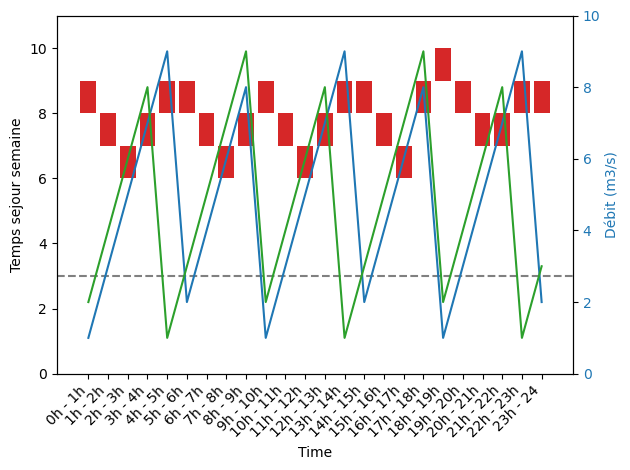

In [11]:
data_type = input("Entrer 'semaine' pour l'hydrogramme en semaine ou 'weekend' pour l'hydrogramme en weekend: ")

if data_type == 'semaine':
    calcul_temps_sejour.plot_data(result_table, calcul_temps_sejour.seuil_tempssej, data_type)
elif data_type == 'weekend':
    calcul_temps_sejour.plot_data(result_table, calcul_temps_sejour.seuil_tempssej, data_type)
else:
    print("Invalid input. Please enter 'semaine' or 'weekend'.")

### Calcul du nombre de chasses ###

In [12]:
chasses_semaine, chasses_weekend = calcul_temps_sejour.chasses_par_jour(table_df, volume)
print("Nombre de chasses par jour pour la semaine:", chasses_semaine)
print("Nombre de chasses par jour pour le weekend:", chasses_weekend)

Nombre de chasses par jour pour la semaine: 3.009475287555839
Nombre de chasses par jour pour le weekend: 2.9323092545415865


## Extrapolation ##

### Calcul des débits cumulés par tranches horaires ###

In [16]:
extrap_table_df = calcul_temps_sejour.creer_extrap_table(table_df, -70, 15)
debit_extrap_semaine = calcul_temps_sejour.calcul_cumul_debits(extrap_table_df, 'Semaine m3/s')
debit_extrap_weekend = calcul_temps_sejour.calcul_cumul_debits(extrap_table_df, 'Weekend m3/s')

### Calcul du temps de séjour en fonction des horaires  ###

In [18]:
tempssej_extrap_semaine = calcul_temps_sejour.table_temps_sejour(debit_extrap_semaine, volume)
tempssej_extrap_weekend = calcul_temps_sejour.table_temps_sejour(debit_extrap_weekend, volume)

### Tableau de synthèse des temps de séjour ###

In [ ]:
extrapolated_result = calcul_temps_sejour.table_synthese(extrap_table_df, tempssej_extrap_semaine, tempssej_extrap_weekend)

### Analyse des hydrogrammes moyens de temps sec ### 

In [ ]:
data_type = input("Enter 'semaine' to plot data for semaine or 'weekend' to plot data for weekend: ")

if data_type == 'semaine':
    calcul_temps_sejour.plot_data(extrapolated_result, calcul_temps_sejour.seuil_tempssej, data_type)
elif data_type == 'weekend':
    calcul_temps_sejour.plot_data(extrapolated_result, calcul_temps_sejour.seuil_tempssej, data_type)
else:
    print("Invalid input. Please enter 'semaine' or 'weekend'.")

### Calcul du nombre de chasses ###

In [ ]:
chasses_extrap_semaine, chasses_extrap_weekend = calcul_temps_sejour.chasses_par_jour(extrap_table_df, volume)
print("Nombre de chasses par jour pour la semaine:", chasses_extrap_semaine)
print("Nombre de chasses par jour pour le weekend:", chasses_extrap_weekend)